# NBA Predictor - Training Baseline Model

This notebook demonstrates the complete training pipeline:
1. Data preprocessing
2. Baseline model comparisons
3. Logistic Regression training
4. Model evaluation
5. Feature inspection
6. Prediction examples

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
sys.path.append('../src')

from nba_predictor import config
from nba_predictor.data_prep import load_raw_data, create_label, split_data
from nba_predictor.train_baseline import create_baseline_pipeline, prepare_features_labels
from nba_predictor.evaluate import compute_metrics, compute_baseline_metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

%matplotlib inline
sns.set_style('darkgrid')
np.random.seed(config.RANDOM_SEED)

print(f"Random seed: {config.RANDOM_SEED}")

Random seed: 42


## 2. Load and Prepare Data

In [2]:
# Load raw data
print("Loading data...")
df = load_raw_data()

# Create labels
df = create_label(df)

# Split with time-based validation
train_df, test_df = split_data(df)

print(f"\nTrain set: {len(train_df):,} games")
print(f"Test set: {len(test_df):,} games")

Loading data...
Loading data from c:\Users\andre\Desktop\sandbox\nba-predictor\notebooks\..\data\raw\games.csv...
Dropped 99 rows with missing values
Loaded 26,552 games from 2003-10-05 to 2022-12-22
Home win rate: 0.589 (15,645 / 26,552 games)

Splitting data (train ratio: 0.8)...
Train: 21,238 games (2003-10-05 to 2018-12-13)
Test:  5,314 games (2018-12-14 to 2022-12-22)
✓ No data leakage detected (train dates < test dates)

Train set: 21,238 games
Test set: 5,314 games


In [3]:
# Display sample rows from train set
train_df[[config.GAME_DATE_COL, config.HOME_TEAM_COL, config.VISITOR_TEAM_COL,
          config.HOME_PTS_COL, config.AWAY_PTS_COL, config.LABEL_COL]].head()

,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,PTS_home,PTS_away,home_win
0,2003-10-05,1610612762,1610612742,90.0,85.0,1
1,2003-10-06,1610612763,1610612749,105.0,94.0,1
2,2003-10-07,1610612764,1610612752,104.0,86.0,1
3,2003-10-07,1610612758,1610612746,101.0,82.0,1
4,2003-10-07,1610612757,1610612745,104.0,80.0,1


## 3. Examine Features

In [4]:
# Prepare features and labels
X_train, y_train = prepare_features_labels(train_df)
X_test, y_test = prepare_features_labels(test_df)

print(f"Feature columns: {config.FEATURE_COLS}")
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

print(f"\nUnique teams:")
print(f"  Home teams: {X_train[config.HOME_TEAM_COL].nunique()}")
print(f"  Visitor teams: {X_train[config.VISITOR_TEAM_COL].nunique()}")

print(f"\nFeature encoding: One-hot encoding will be applied")
print(f"Expected features after encoding: {X_train[config.HOME_TEAM_COL].nunique() + X_train[config.VISITOR_TEAM_COL].nunique()}")

Feature columns: ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']

Training features shape: (21238, 2)
Test features shape: (5314, 2)

Unique teams:
  Home teams: 30
  Visitor teams: 30

Feature encoding: One-hot encoding will be applied
Expected features after encoding: 60


In [5]:
# Show example features
print("Example matchups (first 5):")
X_train.head()

Example matchups (first 5):


,HOME_TEAM_ID,VISITOR_TEAM_ID
0,1610612762,1610612742
1,1610612763,1610612749
2,1610612764,1610612752
3,1610612758,1610612746
4,1610612757,1610612745


## 4. Baseline Models

Before training our model, let's establish baselines to beat.

In [6]:
# Baseline 1: Always predict home win
baseline1_proba = np.ones_like(y_test, dtype=float)
baseline1_metrics = compute_metrics(y_test, baseline1_proba)

print("Baseline 1: Always Predict Home Win")
print(f"  Log Loss: {baseline1_metrics['log_loss']:.4f}")
print(f"  ROC AUC: {baseline1_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {baseline1_metrics['accuracy']:.4f}")

Baseline 1: Always Predict Home Win
  Log Loss: 16.0073
  ROC AUC: 0.5000
  Accuracy: 0.5559


In [7]:
# Baseline 2: Constant probability = training home win rate
train_home_win_rate = y_train.mean()
baseline2_proba = np.full_like(y_test, fill_value=train_home_win_rate, dtype=float)
baseline2_metrics = compute_metrics(y_test, baseline2_proba)

print(f"Baseline 2: Constant Probability = {train_home_win_rate:.3f}")
print(f"  Log Loss: {baseline2_metrics['log_loss']:.4f}")
print(f"  ROC AUC: {baseline2_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {baseline2_metrics['accuracy']:.4f}")

print(f"\n✓ Goal: Beat both baselines on Log Loss")

Baseline 2: Constant Probability = 0.598
  Log Loss: 0.6905
  ROC AUC: 0.5000
  Accuracy: 0.5559

✓ Goal: Beat both baselines on Log Loss


## 5. Train Logistic Regression

In [8]:
# Create and train pipeline
print("Creating pipeline...")
pipeline = create_baseline_pipeline()
print(pipeline)

print("\nTraining model...")
pipeline.fit(X_train, y_train)
print("✓ Training complete!")

Creating pipeline...
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('team_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HOME_TEAM_ID',
                                                   'VISITOR_TEAM_ID'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

Training model...
✓ Training complete!


## 6. Evaluate Model

In [9]:
# Get predictions
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Compute metrics
model_metrics = compute_metrics(y_test, y_pred_proba)

print("Model Performance on Test Set:")
print(f"  Log Loss: {model_metrics['log_loss']:.4f}")
print(f"  ROC AUC: {model_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {model_metrics['accuracy']:.4f}")

Model Performance on Test Set:
  Log Loss: 0.7070
  ROC AUC: 0.5160
  Accuracy: 0.5410


In [10]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Always Home', 'Constant Prob'],
    'Log Loss': [model_metrics['log_loss'], baseline1_metrics['log_loss'], baseline2_metrics['log_loss']],
    'ROC AUC': [model_metrics['roc_auc'], baseline1_metrics['roc_auc'], baseline2_metrics['roc_auc']],
    'Accuracy': [model_metrics['accuracy'], baseline1_metrics['accuracy'], baseline2_metrics['accuracy']]
}).set_index('Model')

print("\n" + "="*60)
print("Model vs Baselines Comparison")
print("="*60)
print(comparison.to_string())
print("="*60)

if model_metrics['log_loss'] < min(baseline1_metrics['log_loss'], baseline2_metrics['log_loss']):
    print("\n✓ SUCCESS: Model beats both baselines!")
else:
    print("\n✗ Model does not beat baselines")


Model vs Baselines Comparison
                      Log Loss   ROC AUC  Accuracy
Model                                             
Logistic Regression   0.706953  0.516002  0.541024
Always Home          16.007343  0.500000  0.555890
Constant Prob         0.690461  0.500000  0.555890

✗ Model does not beat baselines


## 7. ROC Curve Visualization

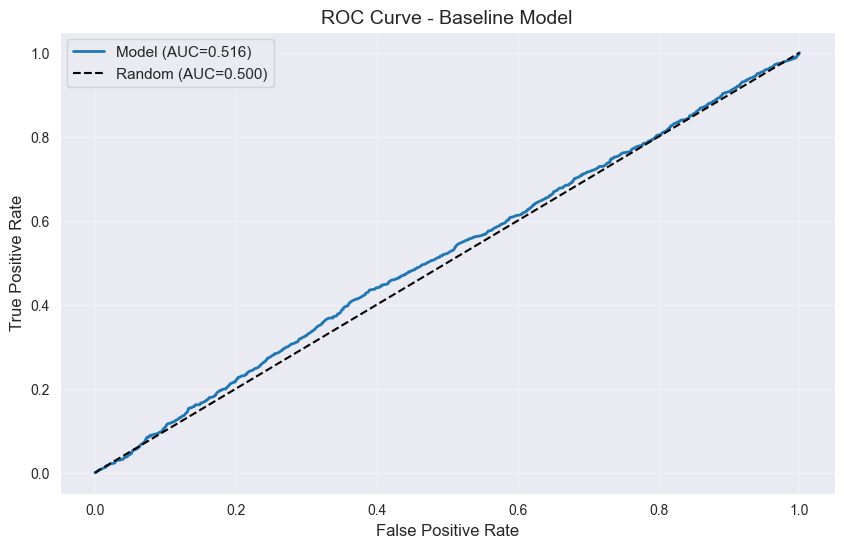

In [11]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Model (AUC={model_metrics["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Model', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

## 8. Confusion Matrix

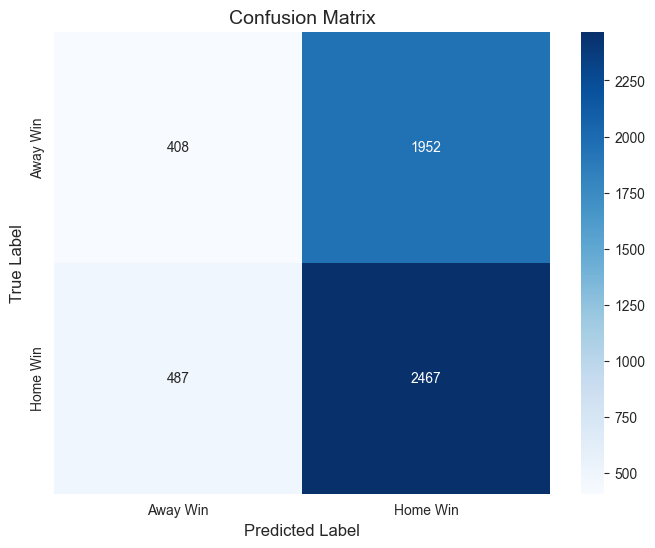

True Negatives (correct away wins): 408
False Positives (predicted home, actual away): 1,952
False Negatives (predicted away, actual home): 487
True Positives (correct home wins): 2,467


In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

print(f"True Negatives (correct away wins): {cm[0,0]:,}")
print(f"False Positives (predicted home, actual away): {cm[0,1]:,}")
print(f"False Negatives (predicted away, actual home): {cm[1,0]:,}")
print(f"True Positives (correct home wins): {cm[1,1]:,}")

## 9. Calibration Plot

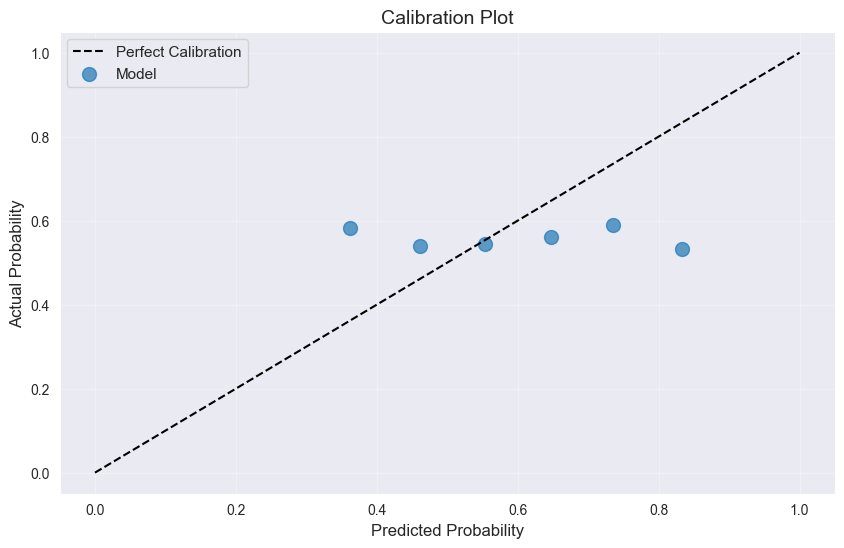

Calibration: Points closer to diagonal = better calibrated


In [13]:
# Calibration analysis
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

bin_indices = np.digitize(y_pred_proba, bins) - 1
bin_indices = np.clip(bin_indices, 0, n_bins - 1)

actual_probs = []
predicted_probs = []

for i in range(n_bins):
    mask = bin_indices == i
    if mask.sum() > 0:
        actual_probs.append(y_test[mask].mean())
        predicted_probs.append(y_pred_proba[mask].mean())
    else:
        actual_probs.append(np.nan)
        predicted_probs.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.scatter(predicted_probs, actual_probs, s=100, alpha=0.7, label='Model')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Actual Probability', fontsize=12)
plt.title('Calibration Plot', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("Calibration: Points closer to diagonal = better calibrated")

## 10. Feature Inspection

In [14]:
# Extract coefficients from Logistic Regression
lr_model = pipeline.named_steps['classifier']
coefficients = lr_model.coef_[0]

# Get feature names from OneHotEncoder
encoder = pipeline.named_steps['preprocessor'].named_transformers_['team_encoder']
feature_names = encoder.get_feature_names_out(config.FEATURE_COLS)

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', ascending=False)

print(f"Total features: {len(feature_names)}")
print(f"\nTop 10 strongest features (positive coefficients):")
print(coef_df.head(10).to_string(index=False))

print(f"\nBottom 10 weakest features (negative coefficients):")
print(coef_df.tail(10).to_string(index=False))

Total features: 60

Top 10 strongest features (positive coefficients):
                   Feature  Coefficient
   HOME_TEAM_ID_1610612759     0.958171
VISITOR_TEAM_ID_1610612766     0.565960
VISITOR_TEAM_ID_1610612749     0.411823
   HOME_TEAM_ID_1610612744     0.401829
   HOME_TEAM_ID_1610612742     0.400959
   HOME_TEAM_ID_1610612743     0.399938
VISITOR_TEAM_ID_1610612752     0.366690
   HOME_TEAM_ID_1610612745     0.357244
VISITOR_TEAM_ID_1610612755     0.345431
VISITOR_TEAM_ID_1610612758     0.329742

Bottom 10 weakest features (negative coefficients):
                   Feature  Coefficient
   HOME_TEAM_ID_1610612749    -0.265689
   HOME_TEAM_ID_1610612758    -0.332848
VISITOR_TEAM_ID_1610612742    -0.371594
   HOME_TEAM_ID_1610612766    -0.395590
   HOME_TEAM_ID_1610612750    -0.439623
   HOME_TEAM_ID_1610612755    -0.442997
   HOME_TEAM_ID_1610612751    -0.474751
VISITOR_TEAM_ID_1610612745    -0.479541
   HOME_TEAM_ID_1610612752    -0.504581
VISITOR_TEAM_ID_1610612759    -0.685

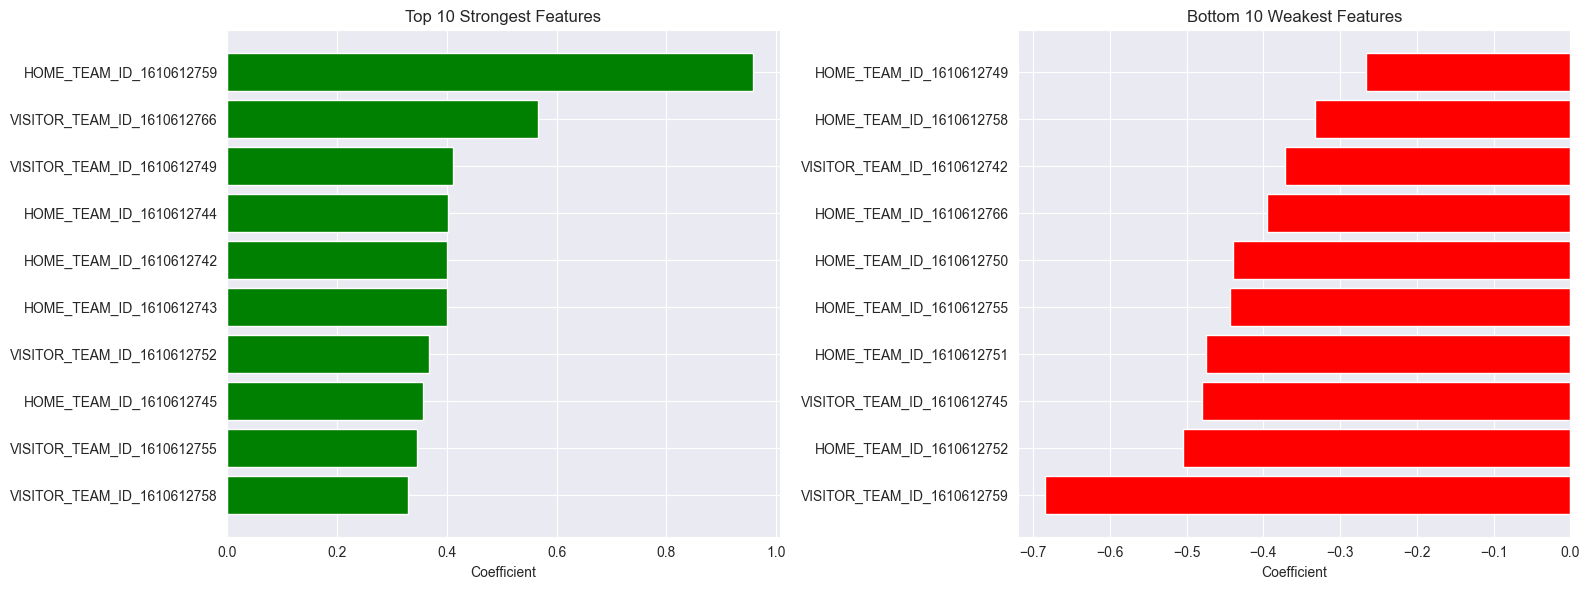

Interpretation:
- Positive coefficients: Increase home win probability
- Negative coefficients: Decrease home win probability


In [15]:
# Visualize top/bottom coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 positive
top_10 = coef_df.head(10)
axes[0].barh(range(len(top_10)), top_10['Coefficient'], color='green')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['Feature'])
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 10 Strongest Features')
axes[0].invert_yaxis()

# Bottom 10 negative
bottom_10 = coef_df.tail(10)
axes[1].barh(range(len(bottom_10)), bottom_10['Coefficient'], color='red')
axes[1].set_yticks(range(len(bottom_10)))
axes[1].set_yticklabels(bottom_10['Feature'])
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Bottom 10 Weakest Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Positive coefficients: Increase home win probability")
print("- Negative coefficients: Decrease home win probability")

## 11. Prediction Examples

In [16]:
# Example predictions
example_games = X_test.head(5)

print("Example Predictions:")
print("=" * 80)

for idx, row in example_games.iterrows():
    home_id = row[config.HOME_TEAM_COL]
    visitor_id = row[config.VISITOR_TEAM_COL]

    # Get prediction
    X_single = pd.DataFrame({config.HOME_TEAM_COL: [home_id], config.VISITOR_TEAM_COL: [visitor_id]})
    prob = pipeline.predict_proba(X_single)[0, 1]
    pred = 'Home' if prob >= 0.5 else 'Away'

    # Get actual result
    actual = 'Home' if y_test[X_test.index.get_loc(idx)] == 1 else 'Away'

    print(f"\nGame: Home Team {home_id} vs Visitor Team {visitor_id}")
    print(f"  Predicted: {pred} (prob: {prob:.3f})")
    print(f"  Actual: {actual}")
    print(f"  Correct: {'✓' if pred == actual else '✗'}")

print("\n" + "=" * 80)

Example Predictions:

Game: Home Team 1610612738 vs Visitor Team 1610612737
  Predicted: Home (prob: 0.668)
  Actual: Home
  Correct: ✓

Game: Home Team 1610612766 vs Visitor Team 1610612752
  Predicted: Home (prob: 0.588)
  Actual: Away
  Correct: ✗

Game: Home Team 1610612751 vs Visitor Team 1610612764
  Predicted: Home (prob: 0.548)
  Actual: Home
  Correct: ✓

Game: Home Team 1610612739 vs Visitor Team 1610612749
  Predicted: Home (prob: 0.715)
  Actual: Away
  Correct: ✗

Game: Home Team 1610612763 vs Visitor Team 1610612748
  Predicted: Home (prob: 0.576)
  Actual: Away
  Correct: ✗



## 12. Save Model

In [17]:
# Save trained model
config.MODELS_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(pipeline, config.BASELINE_MODEL_PATH)
print(f"✓ Model saved to: {config.BASELINE_MODEL_PATH}")

# Test loading
loaded_pipeline = joblib.load(config.BASELINE_MODEL_PATH)
print(f"✓ Model loaded successfully")

# Verify predictions match
test_pred1 = pipeline.predict_proba(X_test.head(1))
test_pred2 = loaded_pipeline.predict_proba(X_test.head(1))
assert np.allclose(test_pred1, test_pred2), "Loaded model predictions don't match!"
print(f"✓ Loaded model predictions match original")

✓ Model saved to: c:\Users\andre\Desktop\sandbox\nba-predictor\notebooks\..\models\baseline.joblib
✓ Model loaded successfully
✓ Loaded model predictions match original


## 13. Summary and Next Steps

In [18]:
print("="*80)
print("TRAINING SUMMARY")
print("="*80)

print(f"\n✓ Model: Logistic Regression with one-hot encoded team IDs")
print(f"✓ Train/Test Split: Time-based (no leakage)")
print(f"✓ Training set: {len(train_df):,} games")
print(f"✓ Test set: {len(test_df):,} games")

print(f"\nPerformance on Test Set:")
print(f"  Log Loss: {model_metrics['log_loss']:.4f}")
print(f"  ROC AUC: {model_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {model_metrics['accuracy']:.4f}")

print(f"\nComparison to Baselines:")
print(f"  Always Home: {baseline1_metrics['log_loss']:.4f} {'✓' if model_metrics['log_loss'] < baseline1_metrics['log_loss'] else '✗'}")
print(f"  Constant Prob: {baseline2_metrics['log_loss']:.4f} {'✓' if model_metrics['log_loss'] < baseline2_metrics['log_loss'] else '✗'}")

print(f"\n✓ Model saved to: {config.BASELINE_MODEL_PATH}")

print("\nNext Steps for v1.1:")
print("  1. Add season as categorical feature")
print("  2. Add rolling team statistics (last-10 win%, point differential)")
print("  3. Add rest days between games")
print("  4. Experiment with advanced models (Random Forest, XGBoost)")
print("  5. Hyperparameter tuning with GridSearchCV")

print("\nNext Steps for v2:")
print("  1. Build FastAPI REST endpoint for predictions")
print("  2. Create web UI (Streamlit or React)")
print("  3. Set up automated retraining pipeline")

print("\n" + "="*80)

TRAINING SUMMARY

✓ Model: Logistic Regression with one-hot encoded team IDs
✓ Train/Test Split: Time-based (no leakage)
✓ Training set: 21,238 games
✓ Test set: 5,314 games

Performance on Test Set:
  Log Loss: 0.7070
  ROC AUC: 0.5160
  Accuracy: 0.5410

Comparison to Baselines:
  Always Home: 16.0073 ✓
  Constant Prob: 0.6905 ✗

✓ Model saved to: c:\Users\andre\Desktop\sandbox\nba-predictor\notebooks\..\models\baseline.joblib

Next Steps for v1.1:
  1. Add season as categorical feature
  2. Add rolling team statistics (last-10 win%, point differential)
  3. Add rest days between games
  4. Experiment with advanced models (Random Forest, XGBoost)
  5. Hyperparameter tuning with GridSearchCV

Next Steps for v2:
  1. Build FastAPI REST endpoint for predictions
  2. Create web UI (Streamlit or React)
  3. Set up automated retraining pipeline

